In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure


class labAnalysisHelper:
    def __init__(self, imagePath):
        self.imagePath = imagePath
        self.extension = imagePath.split(".")[-1]
        self.image = cv.imread(self.imagePath, 0)
        self.currentImage = self.image

    def selectDefaultIfNone(self, image=None):
        if image is None:
            image = self.currentImage
        return image
        
    def showImage(self, image=None, title="Image"):
        image = self.selectDefaultIfNone(image)
        
        plt.figure(figsize=(10, 10))
        plt.title(title)
        plt.imshow(image, cmap='gray')
        plt.show()

    def showHistogram(self, image=None, title="Histogram"):
        image = self.selectDefaultIfNone(image)
        
        plt.figure(figsize=(10, 10))
        plt.title(title)
        plt.hist(image.ravel(), 256, [0, 256])
        plt.show()

    def saveImage(self, name="output", image=None, folder="output"):
        image = self.selectDefaultIfNone(image)
        
        cv.imwrite(f"{folder}/{name}.{self.extension}", image)
        print(f"Saved {folder}/{name}.{self.extension}")

    def removeOutterEdge(self, image=None, radius=5550):
        image = self.selectDefaultIfNone(image)

        mask = np.zeros(image.shape, np.uint8)
        cv.circle(mask, (image.shape[0]//2, image.shape[1]//2), radius, 255, -1)
        masked = cv.bitwise_and(image, image, mask=mask)

        self.currentImage = masked

        return masked
    

    def applyOtsuThreshold(self, image=None):
        image = self.selectDefaultIfNone(image)
        
        ret, thresh = cv.threshold(image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
        self.currentImage = thresh
        print(f"Otsu threshold: {ret}")

        return thresh
    
    def applyThreshold(self, threshold=127, image=None):
        image = self.selectDefaultIfNone(image)
        
        ret, thresh = cv.threshold(image, threshold, 255, cv.THRESH_BINARY)
        self.currentImage = thresh
        print(f"Threshold: {ret}")

        return thresh
    
    def applyWaterShed(self, binaryImage=None):

        binaryImage = self.selectDefaultIfNone(binaryImage)
        dist3d = cv.cvtColor(binaryImage, cv.COLOR_GRAY2BGR)
        dist3d = dist3d.astype(np.uint8)
        # noise removal
        kernel = np.ones((3,3),np.uint8)
        opening = cv.morphologyEx(binaryImage,cv.MORPH_OPEN,kernel, iterations = 2)
        # sure background area
        sure_bg = cv.dilate(opening,kernel,iterations=3)
        # Finding sure foreground area
        dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
        ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)
        # Finding unknown region
        sure_fg = np.uint8(sure_fg)
        unknown = cv.subtract(sure_bg,sure_fg)

        # Marker labelling
        ret, markers = cv.connectedComponents(sure_fg)
        # Add one to all labels so that sure background is not 0, but 1
        markers = markers+1
        # Now, mark the region of unknown with zero
        markers[unknown==255] = 0

        markers = cv.watershed(dist3d, markers)
        imgcopy = dist3d.copy()
        imgcopy[markers == -1] = [0, 255, 0]

        #draw circles on the image to show the center of the circles and the radius
        for i in range(0, len(markers)):
            for j in range(0, len(markers[i])):
                if markers[i][j] == -1:
                    cv.circle(imgcopy, (j, i), 10, (0, 255, 0), 2)

        self.currentImage = imgcopy


In [17]:

folder = "output_2023-02-02_MM-parameter_Jillian02_0h_DAPI_HC2"
labAnalysis = labAnalysisHelper("2023-02-02_MM-parameter_Jillian02_0h_DAPI_HC2.jpg")


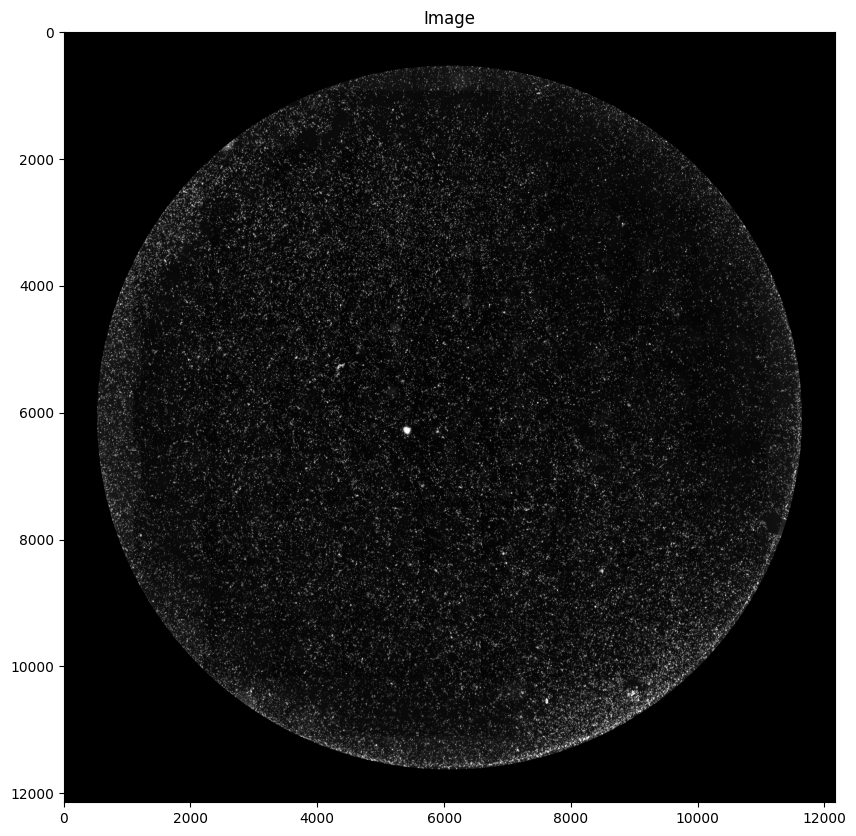

In [18]:
removedOutterEdge = labAnalysis.removeOutterEdge()
labAnalysis.showImage()


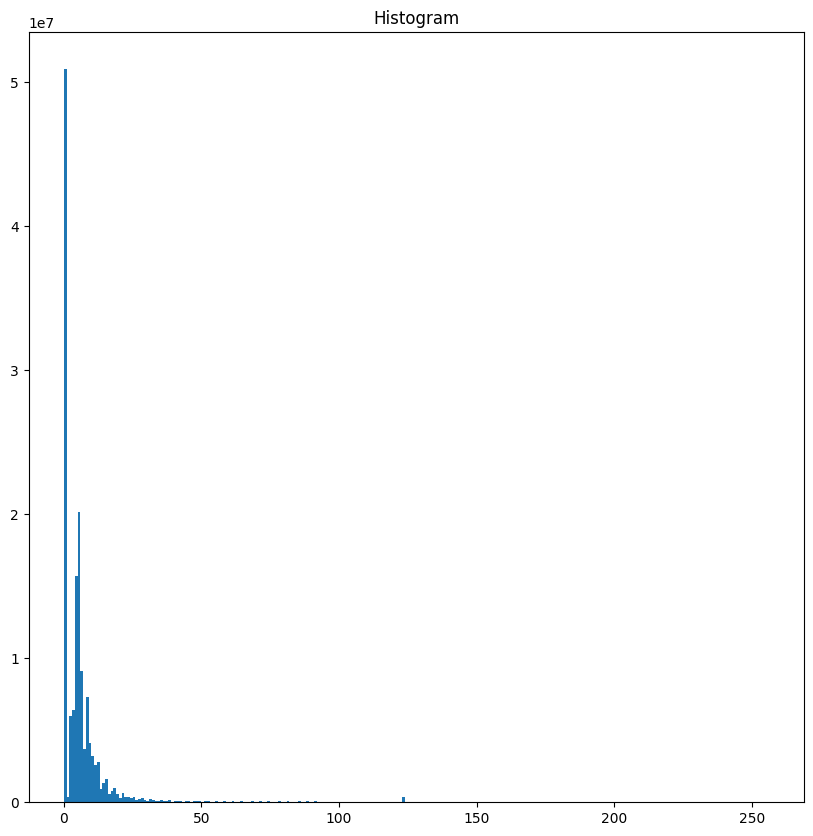

In [19]:
labAnalysis.showHistogram()

Threshold: 42.0


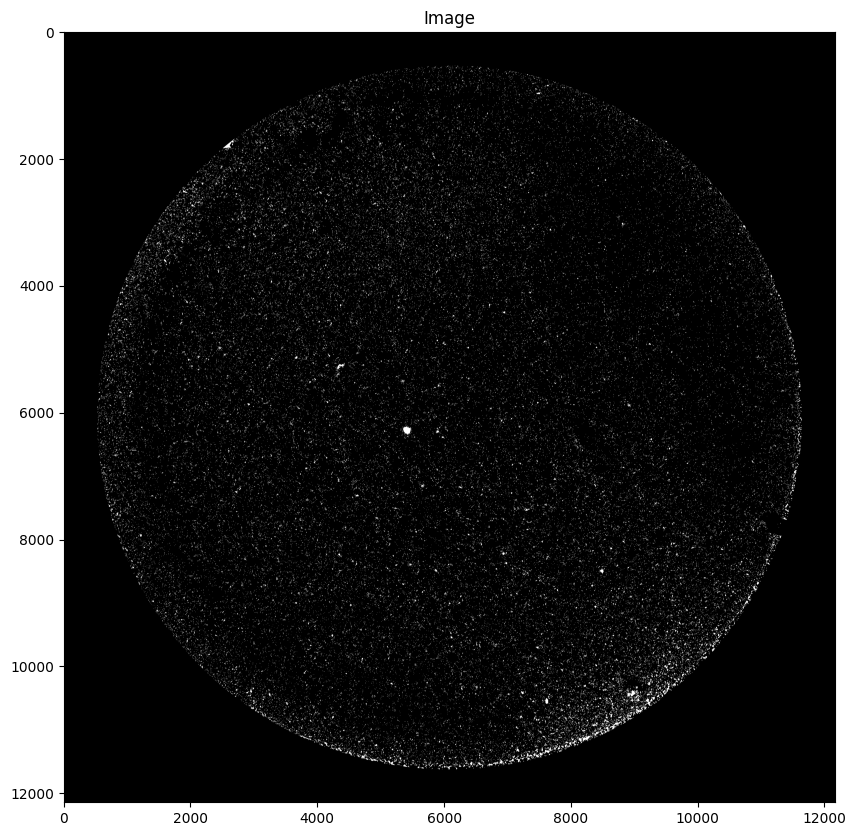

Saved output/thresholded.jpg


In [20]:

labAnalysis.applyThreshold(42, removedOutterEdge)
labAnalysis.showImage()
labAnalysis.saveImage("thresholded")
thresholded = labAnalysis.currentImage.copy()

## Circle detection on the image without watershed

In [21]:
finalCopyAnnotated = cv.imread("image1.jpg")


# Find all the regions in thresholded that have a surface area of more than 113 pixels
# and label them
ret, labels = cv.connectedComponents(thresholded)

print(ret)
print(labels.shape)

component_sizes = np.bincount(labels.flat)
large_components = np.where(component_sizes > 113)[0]
mask = np.zeros(labels.shape, dtype=np.uint8)
mask[np.isin(labels, large_components)] = 255

bigRegionsMask = cv.bitwise_and(mask, mask, mask=thresholded)

totalNumberOfCellsForBigRegions = 0

contours, hierarchy = cv.findContours(bigRegionsMask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Loop over the contours
for cnt in contours:
    # Find the area of the contour
    area = cv.contourArea(cnt)

    # Find the centroid of the contour
    M = cv.moments(cnt)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])

    numberOfCells = int(area/30)
    totalNumberOfCellsForBigRegions += numberOfCells

    # Draw a circle and text on the original image
    cv.circle(finalCopyAnnotated, (cX, cY), 10, (0, 255, 0), 1)
    cv.putText(finalCopyAnnotated, str(numberOfCells), (cX - 20, cY - 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

# Show the original image with the circles
labAnalysis.saveImage("maskOfBigRegions", finalCopyAnnotated)


85265
(12144, 12160)
Saved output/maskOfBigRegions.jpg


In [22]:
notBigRegion = cv.bitwise_not(bigRegionsMask)
thresholdedWithoutBigRegions = cv.bitwise_and(thresholded, thresholded, mask=notBigRegion)

circles = cv.HoughCircles(thresholdedWithoutBigRegions,cv.HOUGH_GRADIENT,1,5, param1=10,param2=5,minRadius=1,maxRadius=6)
print(circles)
print(circles.shape)
circles = np.uint16(np.around(circles))


[[[5.18150e+03 6.56350e+03 4.60000e+00]
  [3.43350e+03 4.96350e+03 3.30000e+00]
  [6.20850e+03 2.34650e+03 3.30000e+00]
  ...
  [9.74950e+03 5.55150e+03 1.25000e+00]
  [1.00255e+04 7.41350e+03 1.25000e+00]
  [1.08845e+04 4.62650e+03 1.25000e+00]]]
(1, 88182, 3)


In [23]:
totalNumberOfCellsForIndividualCircles = 0

for i in circles[0,:]:
    # draw the outer circle
    cv.circle(finalCopyAnnotated,(i[0],i[1]),i[2],(0,255,0),1)

    totalNumberOfCellsForIndividualCircles += 1

labAnalysis.saveImage("finalAnnonated", finalCopyAnnotated)

Saved output/finalAnnonated.jpg


In [24]:
print(f"Total number of cells: {totalNumberOfCellsForBigRegions + totalNumberOfCellsForIndividualCircles}")

Total number of cells: 115243


## Trying wateershed

**Warning** 

**This section is not working**


uint8


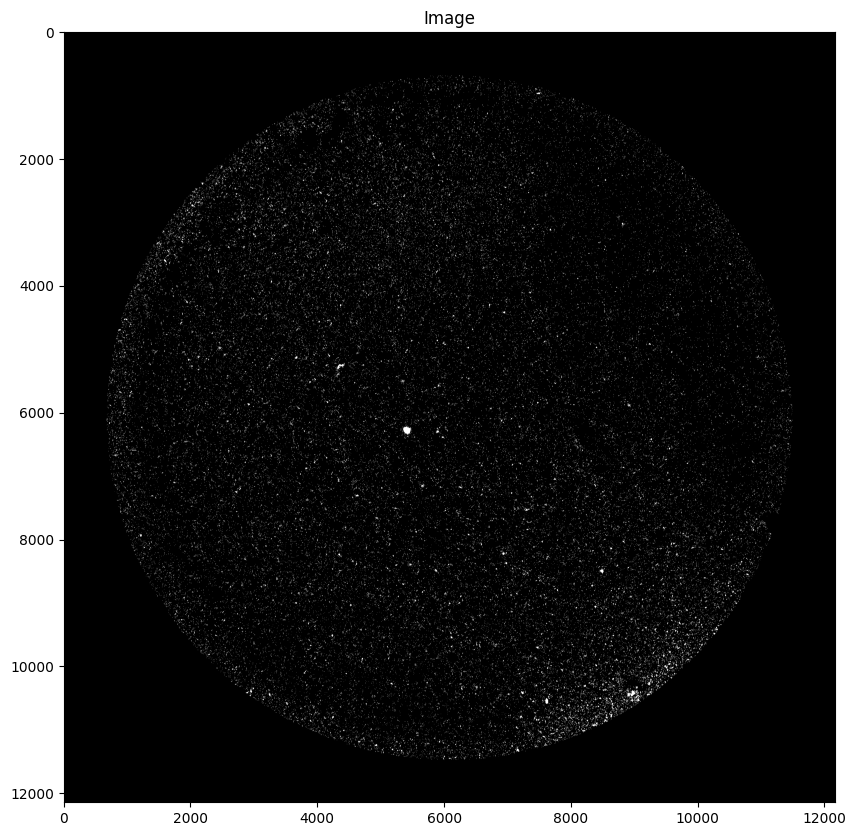

Saved output/opening.jpg


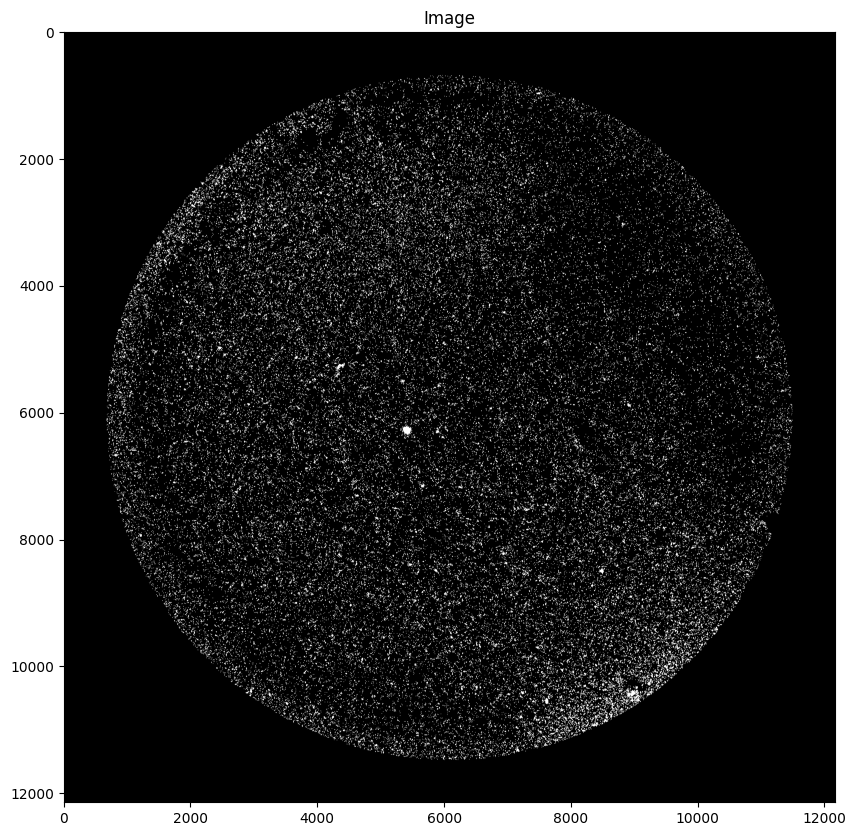

Saved output/sure_bg.jpg


In [42]:
print(labAnalysis.image.dtype)

thresholded = labAnalysis.currentImage.copy()
original = labAnalysis.image.copy()

dist3d = cv.cvtColor(thresholded, cv.COLOR_GRAY2BGR)
dist3d = dist3d.astype(np.uint8)
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresholded,cv.MORPH_OPEN,kernel, iterations = 1)

labAnalysis.showImage(opening)
labAnalysis.saveImage("opening", opening)

# sure background area
sure_bg = cv.dilate(opening,kernel,iterations=2)

labAnalysis.showImage(sure_bg)
labAnalysis.saveImage("sure_bg", sure_bg)




55.0


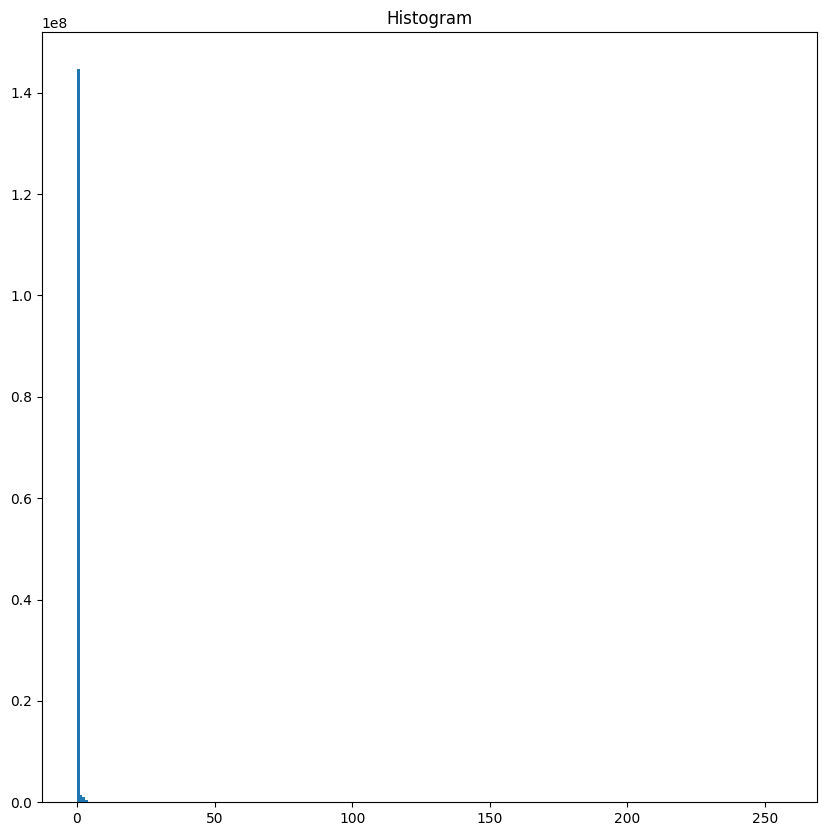

Saved output/dist_transform.jpg
Saved output/sure_fg.jpg
Saved output/unknown.jpg


In [57]:
# Finding sure foreground area
dist_transform = cv.distanceTransform(opening,cv.DIST_L1,5)
print(dist_transform.max())
ret, sure_fg = cv.threshold(dist_transform,2,255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)

labAnalysis.showHistogram(dist_transform)
labAnalysis.saveImage("dist_transform", dist_transform)
labAnalysis.saveImage("sure_fg", sure_fg)
labAnalysis.saveImage("unknown", unknown)



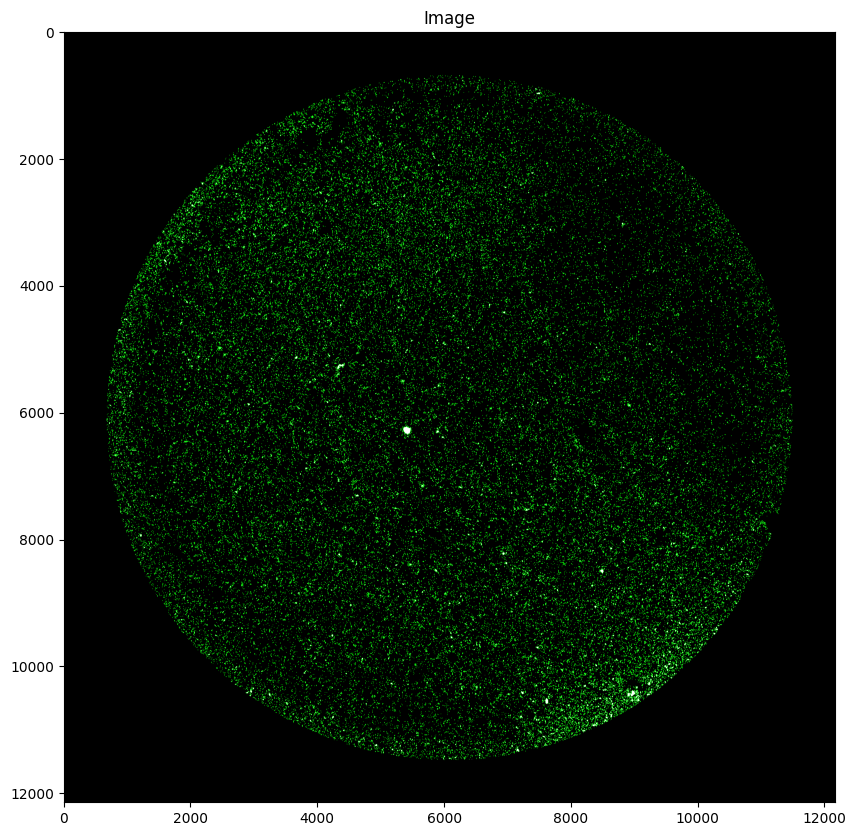

Saved output/watershed.jpg
Saved output/markers.jpg


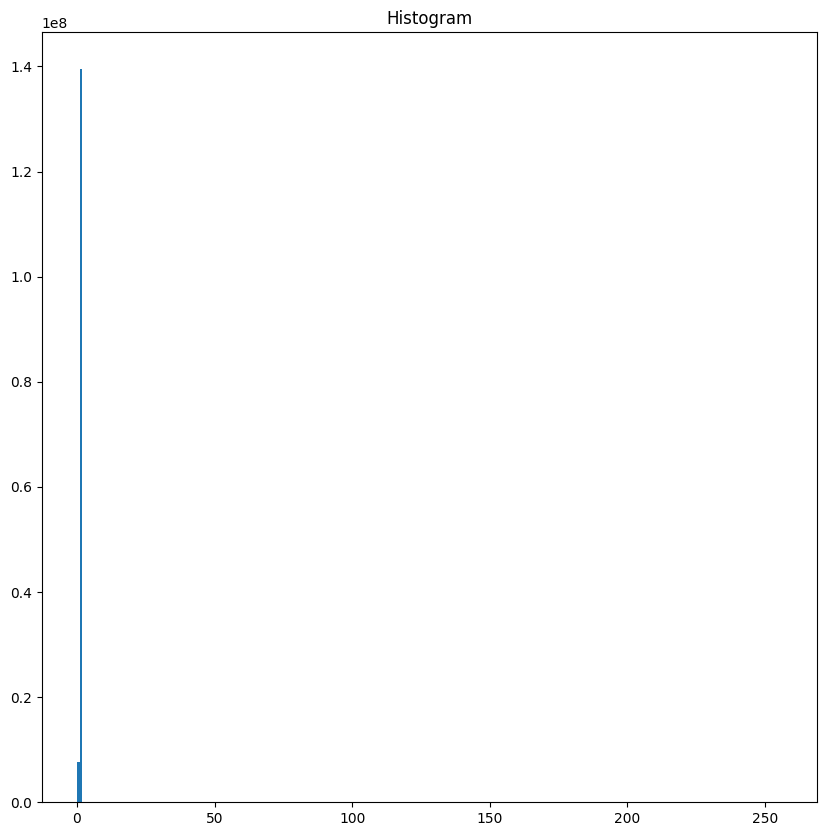

In [67]:
# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0


imgcopy = dist3d.copy()
imgcopy[markers == 0] = [0, 255, 0]

#draw circles on the image to show the center of the circles and the radius
# for i in range(0, len(markers)):
#     for j in range(0, len(markers[i])):
#         if markers[i][j] == -1:
#             cv.circle(imgcopy, (j, i), 3, (0, 0, 100), 1)

labAnalysis.showImage(imgcopy)
labAnalysis.saveImage("watershed", imgcopy)
labAnalysis.saveImage("markers", markers)
labAnalysis.showHistogram(markers)
# self.currentImage = imgcopy

In [ ]:
circles = cv.HoughCircles(img,cv.HOUGH_GRADIENT,1,20,
                            param1=50,param2=30,minRadius=0,maxRadius=0)
circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv.circle(cimg,(i[0],i[1]),2,(0,0,255),3)


# Old version

In [12]:

#import the image that is the result of a microscope that looks at cells
img = cv.imread('image1.jpg',0)

# only select the pixels that are in a circle of radius 100 from the center of the image
# this is to remove the background
radius = 5400
mask = np.zeros(img.shape, np.uint8)
cv.circle(mask, (img.shape[0]//2, img.shape[1]//2), radius, 255, -1)
masked = cv.bitwise_and(img, img, mask=mask)

showBinaryImage(masked, 'Masked')
res = cv.imwrite('masked.jpg', masked)
if res:
    print("Image saved successfully")

NameError: name 'showBinaryImage' is not defined

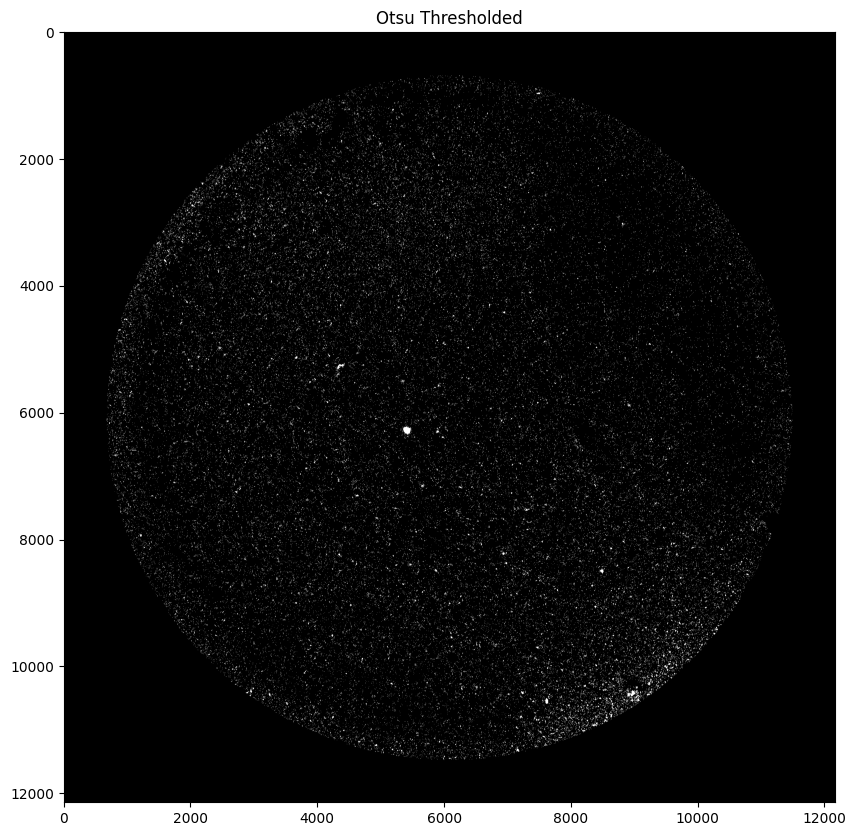

In [43]:

ret,otsuThresholded = cv.threshold(masked,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

cv.imwrite('otsuThresholded.jpg',otsuThresholded)

showBinaryImage(otsuThresholded, 'Otsu Thresholded')


### The purpose of this step is to verify if the quality of our threshold. If we missed some section, it should show up as bright in the middle (similar to the bright on the outter edges)

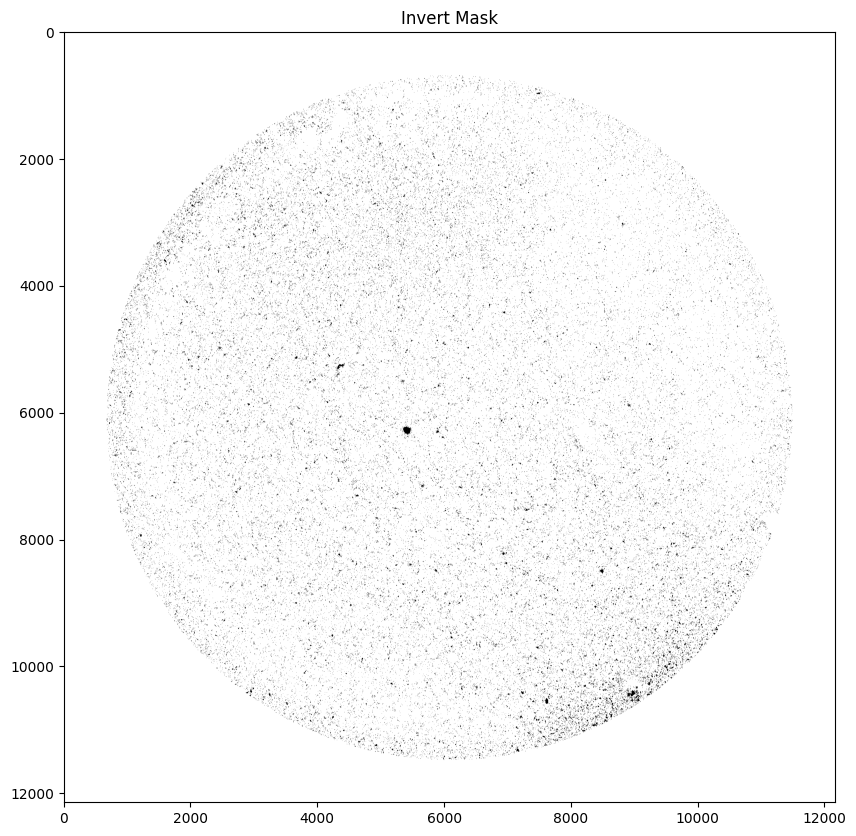

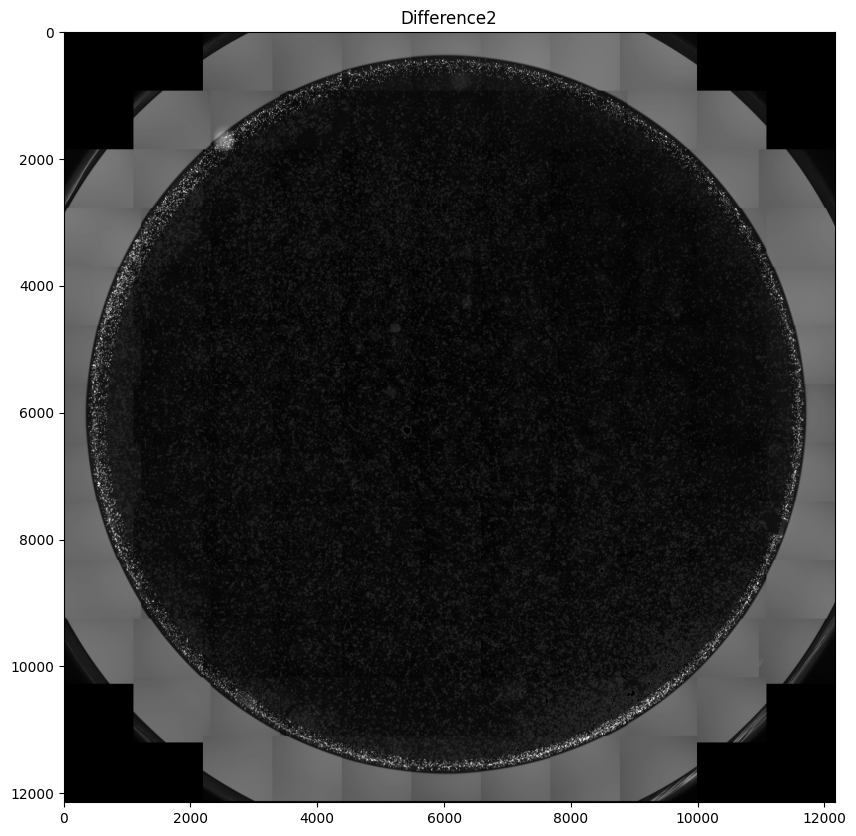

True

In [64]:
# create a invert mask of otsuThresholded
invertMask = cv.bitwise_not(otsuThresholded)

showBinaryImage(invertMask, 'Invert Mask')

# show the original image with the invert mask
difference2 = cv.bitwise_and(img, img, mask=invertMask)


showBinaryImage(difference2, 'Difference2')
cv.imwrite('difference2.jpg',difference2)

In [63]:
# count the ratio of black pixels to white pixels in the otsuThresholded
black = 0
white = 0
for i in range(otsuThresholded.shape[0]):
    for j in range(otsuThresholded.shape[1]):
        if invertMask[i][j] == 0:
            black += 1
        else:
            white += 1
            

Ratio of count of black pixels / white pixels is 45.70354134137243 
